This notebook introduces zero-shot time series forecasting using Sulie’s foundation model, Mimosa, on the **Walmart Sales Dataset** (available on Kaggle). We’ll guide you through setting up and generating forecasts without custom model training—ideal for anticipating demand shifts and improving inventory planning. For details on fine-tuning and advanced configurations, check out our other examples.

### Dependencies

To run this Notebook, ensure the following dependencies are installed:
* `kaggle`
* `sulie`
* `matplotlib`

In this notebook, we’ll forecast using the training data that Mimosa has never seen or been trained on. The forecasts will be made at a store level, demonstrating the model’s ability to generalize and produce accurate predictions.

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random

from sulie import Sulie

To begin using Sulie in your Jupyter notebook, first initialize the Sulie API client. Before proceeding, ensure that you’ve signed up on the Sulie Dashboard and generated an API key. Here’s how you can set up:
1.	Sign up at Sulie Dashboard
2.	Create your API key
3.	Install the Python SDK with the following command:

```bash
pip install sulie
```

For more detailed instructions, refer to our official documentation.

In [2]:
client = Sulie(api_key=os.environ.get("SULIE_API_KEY"))  # Replace with your prefered way of setting the API key

## Time-series data

In this step, we’ll load the Walmart sales dataset to begin our forecasting task. The dataset includes historical sales data for different departments across multiple stores, which is key for understanding seasonal trends and demand patterns.

In [3]:
df = pd.read_csv("./datasets/wallmart-sales/data.csv")

# Swap the column names
df.columns = ["store_id", "dept_id", "date", "weekly_sales", "is_holiday"]

# Cast the sales date to a native Python object
df["date"] = pd.to_datetime(df["date"])

In [4]:
df.head()

,store_id,dept_id,date,weekly_sales,is_holiday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## Datasets

In the following cells, we demonstrate the use of Sulie’s Datasets feature, which provides a simplified interface for managing and interacting with your time series data. This feature is particularly useful for storing, loading, and organizing datasets within Sulie’s ecosystem, making it easier to work with your data directly in the platform.

```{note}
While using Sulie’s Datasets feature can streamline the process, it is entirely optional. If you prefer, you can also load and manipulate your data directly as a pd.DataFrame using typical Pandas methods.
```

### What is Sulie’s Datasets Feature?

Sulie’s Datasets feature allows you to:
* Upload datasets directly to the platform for easier management and version control.
* Access datasets seamlessly within your forecasting pipeline, reducing setup time.
* Share datasets with collaborators, ensuring consistency and reproducibility in your analyses.

By leveraging this feature, you can efficiently store and retrieve data for your forecasting tasks without needing to worry about manual data management.

In [27]:
dataset = client.upload_dataset(
    df=df,
    name="wallmark-sales",
    description=open("./datasets/wallmart-sales/README.md").read()
)

Uploading dataset wallmark-sales: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:55<00:00, 55.1s/B]


## Forecasting with Sulie Foundation Model

The following cells demonstrate how to make time series forecasts based on the provided data using a zero-shot approach with Sulie’s foundation model, Mimosa. This model is designed to handle complex forecasting tasks out of the box without the need for custom training. By leveraging Mimosa, which is built on transformer architecture, we can generate accurate predictions quickly and efficiently.

Mimosa has been trained on vast amounts of time series data and is fine-tuned to handle a variety of forecasting challenges. It supports multiple use cases such as demand forecasting, financial projections, and inventory planning. In this section, you’ll see how to input your data and receive forecasts without any additional training or tuning steps—ideal for users who need rapid insights with minimal setup.

Here are a few details about the options we pass to the `forecast` call:
* `target` - name of the target column to forecast.
* `group_by` - name of the column to group the series by.
* `horizon` - prediction horizon, 24 weeks in advance.
* `num_samples` - sets the number of samples for probabilistic forecasts.

For start, we'll randomly pick a store using its ID and make weekly sales forecasts for that store specifically.

In the following cells, we randomly pick a store ID and select all sales data up until the last 24 data points. These final 24 weekly sales data points will serve as a validation set, allowing us to compare the forecasted values with the actual observed values. This split helps us evaluate the performance and accuracy of the model by testing it on real, unseen data.

In [29]:
_id = random.choice(df["store_id"].unique())

# Sample based on the specific store ID and trim context
store_data = df[df["store_id"] == _id][-512:]

In [30]:
store_data.head()

,store_id,dept_id,date,weekly_sales,is_holiday
107389,11,95,2012-03-02,72301.98,False
107390,11,95,2012-03-09,77844.05,False
107391,11,95,2012-03-16,82281.26,False
107392,11,95,2012-03-23,73670.67,False
107393,11,95,2012-03-30,71300.12,False


In [31]:
low, median, high = client.forecast(
    dataset=store_data[:-24],  # Leave last 24 samples for validation
    target="weekly_sales",
    horizon=24,
    num_samples=100
)

The following cells display a comparison of forecasted vs. actual data points. For each forecast, we provide the 10% quantile, median, and 90% quantile, giving a visual representation of the prediction range and central estimate. This quantile-based approach helps illustrate the model’s confidence in its predictions, with the 10%-90% interval showing potential variability and the median representing the most likely forecast. By comparing these forecasts to the actual observed values, we can assess both accuracy and uncertainty in the model’s predictions.

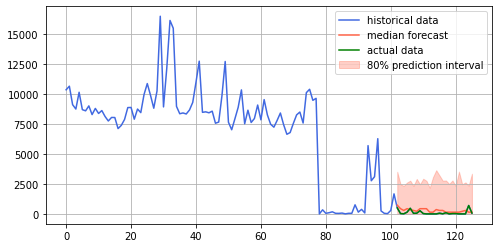

In [32]:
# Limit number of weekly sales data to display
nr_samples = round(store_data.shape[0] * 0.2)

# Range for ploting forecasts
indices = range(nr_samples, nr_samples + 24)

plt.figure(figsize=(8, 4))

plt.plot(store_data[-(nr_samples + 24):]["weekly_sales"].values, color="royalblue", label="historical data")
plt.plot(indices, median, color="tomato", label="median forecast")
plt.plot(indices, store_data[-24:]["weekly_sales"].values, color="green", label="actual data")
plt.fill_between(indices, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.legend()
plt.grid()
plt.show()